# CTDBP

### Purpose
The purpose of this notebook is to calculate the values needed to populate the QARTOD value tables for the Gross Range and Climatology tests as implemented by OOI. The ```CTDBP``` is the sensor name given to the SeaBird SBE16 bottom-pumped CTD. This instrument is deployed on fixed-depth assets on both coastal and global arrays.


### Test Parameters

| Dataset Name | OOINet Name | Range |
| ------------ | ----------- | ----- |
| sea_water_temperature | temp, ctdbp_seawater_temperature | -5 - 35 $^{\circ}$C |
| sea_water_electrical_conductivity | conductivity, ctdbp_seawater_conductivity | 0 - 9 S/cm |
| sea_water_practical_salinity | practical_salinity | 0 - 42 psu |
| sea_water_pressure | pressure, ctdbp_seawater_pressure | 0 - 5000 dbar |

#### Import libraries

In [1]:
import os, sys, datetime, pytz, re
import dateutil.parser as parser
import pandas as pd
import numpy as np
import xarray as xr
import warnings
import gc
import json
warnings.filterwarnings("ignore")

In [2]:
from dask.diagnostics import ProgressBar

#### Import the ```ooinet``` M2M toolbox
This toolbox is publicly available at https://github.com/reedan88/OOINet. It should be cloned onto your machine and the setup instructions followed before use.

In [3]:
# assuming that ooi-data-explorations and OOINet forks are cloned to the same directory
ooinet_path = os.path.abspath("../../../../../../OOINet/.") 
sys.path.append(ooinet_path)
from ooinet import M2M
from ooinet.utils import convert_time, ntp_seconds_to_datetime, unix_epoch_time
from ooinet.Instrument.common import process_file, add_annotation_qc_flag

#### Import ```ooi_data_explorations``` toolbox
This toolbox is publicly available at https://github.com/oceanobservatories/ooi-data-explorations. Similarly to the ```ooinet``` toolbox above, it should be installed onto your machine following the setup instructions before use.

In [4]:
# Import shared analysis tools from the ooi-data-explorations repo
ooi_data_expl_path = os.path.abspath("../../../../../python/.")
sys.path.append(ooi_data_expl_path)
from ooi_data_explorations.common import get_annotations, get_vocabulary, load_gc_thredds
from ooi_data_explorations.combine_data import combine_datasets
from ooi_data_explorations.uncabled.process_ctdbp import ctdbp_datalogger, ctdbp_instrument
from ooi_data_explorations.qartod.qc_processing import identify_blocks, create_annotations, process_gross_range, \
    process_climatology, parse_qc, inputs, ANNO_HEADER, CLM_HEADER, GR_HEADER

#### Import plotting and visualization tools

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from ooi_data_explorations.qartod.plotting import *

---
## Datasets
Identify all of the OOI-CGSN CTD datasets available on OOINet. Since this can be a slow process, we save the results of the query to a local directory. If all the datasets have previously been identified, then want to simply load the identified data streams from local memory:

In [7]:
# Try to load the CGSN DOSTA datasets
try:
    datasets = pd.read_csv("data/CTDBP_datasets.csv")
# If they haven't been downloaded yet
except:
    print("Downloading Dataset list...")
    # add lines here to do "mkdir data" within this cell (but go back to python for rest of cell)
    !mkdir data
    datasets = M2M.search_datasets(instrument="CTDBP", English_names=True)
    # Filter for the CGSN datasets - the array name with start with either CP, GA, GI, GP, or GS
    cgsn = datasets["array"].apply(lambda x: True if x.startswith(("CP","GA","GI","GP","GS")) else False)
    datasets = datasets[cgsn]
    # Save the datasets
    datasets.to_csv("./data/CTDBP_datasets.csv", index=False)

Separate out the CGSN datasets from the EA and RCA datasets:

In [8]:
cgsn = datasets["array"].apply(lambda x: True if x.startswith(("CP","GA","GI","GP","GS")) else False)
datasets = datasets[cgsn]
# This part might already happen while downloading the csv list of datasets

Remove the CTDs that are mounted on gliders and AUVs ("MOAS")

In [9]:
moas = datasets["array"].apply(lambda x: True if "MOAS" in x else False)
datasets = datasets[~moas]
datasets

,array,array_name,node,node_name,instrument,instrument_name,refdes,url,deployments
0,GS01SUMO,Global Southern Ocean Apex Surface Mooring,RII11,Mooring Riser,02-CTDBPP033,CTD (130 meters),GS01SUMO-RII11-02-CTDBPP033,https://ooinet.oceanobservatories.org/api/m2m/...,"[2, 3, 4]"
1,GS01SUMO,Global Southern Ocean Apex Surface Mooring,RII11,Mooring Riser,02-CTDBPP032,CTD (80 meters),GS01SUMO-RII11-02-CTDBPP032,https://ooinet.oceanobservatories.org/api/m2m/...,"[2, 3, 4]"
2,GS01SUMO,Global Southern Ocean Apex Surface Mooring,RII11,Mooring Riser,02-CTDBPP031,CTD (40 meters),GS01SUMO-RII11-02-CTDBPP031,https://ooinet.oceanobservatories.org/api/m2m/...,"[2, 3, 4]"
3,GS01SUMO,Global Southern Ocean Apex Surface Mooring,RID16,Near Surface Instrument Frame,03-CTDBPF000,CTD,GS01SUMO-RID16-03-CTDBPF000,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4]"
4,GI01SUMO,Global Irminger Sea Apex Surface Mooring,RII11,Mooring Riser,02-CTDBPP033,CTD (130 meters),GI01SUMO-RII11-02-CTDBPP033,https://ooinet.oceanobservatories.org/api/m2m/...,"[2, 3, 4, 5, 6, 7, 8, 9]"
5,GI01SUMO,Global Irminger Sea Apex Surface Mooring,RII11,Mooring Riser,02-CTDBPP032,CTD (80 meters),GI01SUMO-RII11-02-CTDBPP032,https://ooinet.oceanobservatories.org/api/m2m/...,"[2, 3, 4, 5, 6, 7, 8, 9]"
6,GI01SUMO,Global Irminger Sea Apex Surface Mooring,RII11,Mooring Riser,02-CTDBPP031,CTD (40 meters),GI01SUMO-RII11-02-CTDBPP031,https://ooinet.oceanobservatories.org/api/m2m/...,"[2, 3, 4, 5, 6, 7, 8, 9]"
7,GI01SUMO,Global Irminger Sea Apex Surface Mooring,RID16,Near Surface Instrument Frame,03-CTDBPF000,CTD,GI01SUMO-RID16-03-CTDBPF000,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8, 9]"
8,GA01SUMO,Global Argentine Basin Apex Surface Mooring,RII11,Mooring Riser,02-CTDBPP033,CTD (130 meters),GA01SUMO-RII11-02-CTDBPP033,https://ooinet.oceanobservatories.org/api/m2m/...,"[2, 3]"
9,GA01SUMO,Global Argentine Basin Apex Surface Mooring,RII11,Mooring Riser,02-CTDBPP032,CTD (80 meters),GA01SUMO-RII11-02-CTDBPP032,https://ooinet.oceanobservatories.org/api/m2m/...,"[2, 3]"


---
## Single Reference Designator
The reference designator acts as a key for an instrument located at a specific location. First, select a reference designator (refdes) to request data from OOINet.

In [10]:
reference_designators = sorted(datasets["refdes"])
print("Number of reference designators: " + str(len(reference_designators)))
for refdes in reference_designators:
    print(refdes)

Number of reference designators: 18
CP01CNSM-MFD37-03-CTDBPD000
CP01CNSM-RID27-03-CTDBPC000
CP03ISSM-MFD37-03-CTDBPD000
CP03ISSM-RID27-03-CTDBPC000
CP04OSSM-MFD37-03-CTDBPE000
CP04OSSM-RID27-03-CTDBPC000
GA01SUMO-RID16-03-CTDBPF000
GA01SUMO-RII11-02-CTDBPP031
GA01SUMO-RII11-02-CTDBPP032
GA01SUMO-RII11-02-CTDBPP033
GI01SUMO-RID16-03-CTDBPF000
GI01SUMO-RII11-02-CTDBPP031
GI01SUMO-RII11-02-CTDBPP032
GI01SUMO-RII11-02-CTDBPP033
GS01SUMO-RID16-03-CTDBPF000
GS01SUMO-RII11-02-CTDBPP031
GS01SUMO-RII11-02-CTDBPP032
GS01SUMO-RII11-02-CTDBPP033


Select a single reference designator (for development)

In [11]:
k=0
refdes = reference_designators[k]
print(refdes)

CP01CNSM-MFD37-03-CTDBPD000


#### Sensor Vocab
The vocab provides information about the instrument model and type, its location (with descriptive names), depth, and manufacturer. Get the vocab for the given reference designator.

In [12]:
vocab = M2M.get_vocab(refdes)
vocab

,@class,vocabId,refdes,instrument,tocL1,tocL2,tocL3,manufacturer,model,mindepth,maxdepth
0,.VocabRecord,465,CP01CNSM-MFD37-03-CTDBPD000,CTD,Coastal Pioneer,Central Surface Mooring,Seafloor Multi-Function Node (MFN),Sea-Bird,SBE 16plusV2,133.0,133.0


#### Sensor Deployments
Download the deployment information for the selected reference designator:

In [13]:
deployments = M2M.get_deployments(refdes)
deployments

,deploymentNumber,uid,assetId,latitude,longitude,depth,deployStart,deployEnd,deployCruise,recoverCruise
0,1,CGINS-CTDBPD-07239,2508,40.13678,-70.76978,132.5,2013-11-21 18:16:00,2014-04-18 10:33:00,KN214,KN217
1,2,CGINS-CTDBPD-50008,2880,40.1339,-70.7789,134.0,2014-12-13 18:47:00,2014-12-15 20:58:00,KN224,KN224
2,3,CGINS-CTDBPD-50008,2880,40.14022,-70.77128,134.0,2015-05-07 17:34:00,2015-10-23 19:40:00,AT27,AT31
3,5,CGINS-CTDBPD-50058,2786,40.14037,-70.77133,133.0,2016-05-13 13:50:00,2016-10-13 19:34:00,AR4,AR8
4,6,CGINS-CTDBPD-07209,2804,40.13342,-70.77847,133.0,2016-10-13 18:36:00,2017-06-09 16:05:00,AR8,AR18
5,7,CGINS-CTDBPD-07239,2508,40.139817,-70.77115,133.0,2017-06-09 14:24:00,2017-11-01 20:33:00,AR18,AR24
6,8,CGINS-CTDBPD-07209,2804,40.133383,-70.7783,133.0,2017-10-29 14:15:00,2018-03-29 19:37:00,AR24,AR28
7,9,CGINS-CTDBPD-07239,2508,40.13975,-70.77128,133.0,2018-03-24 21:32:00,2018-10-29 12:31:00,AR28,AR31
8,10,CGINS-CTDBPD-50008,2880,40.133367,-70.7777,133.0,2018-10-30 01:48:00,2019-04-07 18:08:00,AR31,AR34
9,11,CGINS-CTDBPD-50110,3386,40.1401,-70.77137,132.0,2019-04-06 14:35:00,2019-09-26 17:15:00,AR34,AR39


#### Sensor Data Streams
Next, select the specific data streams for the given reference designator

In [14]:
datastreams = M2M.get_datastreams(refdes)
datastreams

,refdes,method,stream
0,CP01CNSM-MFD37-03-CTDBPD000,recovered_host,ctdbp_cdef_dcl_instrument_recovered
1,CP01CNSM-MFD37-03-CTDBPD000,recovered_inst,ctdbp_cdef_instrument_recovered
2,CP01CNSM-MFD37-03-CTDBPD000,telemetered,ctdbp_cdef_dcl_instrument


---
## Metadata 
The metadata contains the following important key pieces of data for each reference designator: **method**, **stream**, **particleKey**, and **count**. The method and stream are necessary for identifying and loading the relevant dataset. The particleKey tells us which data variables in the dataset we should be calculating the QARTOD parameters for. The count lets us know which dataset (the recovered instrument, recovered host, or telemetered) contains the most data and likely has the best record to use to calculate the QARTOD tables. 

In [15]:
metadata = M2M.get_metadata(refdes)
metadata

,pdId,particleKey,type,shape,units,fillValue,stream,unsigned,method,count,beginTime,endTime,refdes
0,PD1,conductivity,FLOAT,SCALAR,S m-1,-9999999,ctdbp_cdef_dcl_instrument,False,telemetered,94001,2013-11-21T18:16:04.560Z,2022-06-15T09:00:07.963Z,CP01CNSM-MFD37-03-CTDBPD000
1,PD2,pressure,FLOAT,SCALAR,dbar,-9999999,ctdbp_cdef_dcl_instrument,False,telemetered,94001,2013-11-21T18:16:04.560Z,2022-06-15T09:00:07.963Z,CP01CNSM-MFD37-03-CTDBPD000
2,PD5,density,FLOAT,FUNCTION,kg m-3,-9999999,ctdbp_cdef_dcl_instrument,False,telemetered,94001,2013-11-21T18:16:04.560Z,2022-06-15T09:00:07.963Z,CP01CNSM-MFD37-03-CTDBPD000
3,PD6,temp,FLOAT,SCALAR,degrees_Celsius,-9999999,ctdbp_cdef_dcl_instrument,False,telemetered,94001,2013-11-21T18:16:04.560Z,2022-06-15T09:00:07.963Z,CP01CNSM-MFD37-03-CTDBPD000
4,PD7,time,DOUBLE,SCALAR,seconds since 1900-01-01,-9999999,ctdbp_cdef_dcl_instrument,False,telemetered,94001,2013-11-21T18:16:04.560Z,2022-06-15T09:00:07.963Z,CP01CNSM-MFD37-03-CTDBPD000
5,PD10,port_timestamp,DOUBLE,SCALAR,seconds since 1900-01-01,-9999999,ctdbp_cdef_dcl_instrument,False,telemetered,94001,2013-11-21T18:16:04.560Z,2022-06-15T09:00:07.963Z,CP01CNSM-MFD37-03-CTDBPD000
6,PD11,driver_timestamp,DOUBLE,SCALAR,seconds since 1900-01-01,-9999999,ctdbp_cdef_dcl_instrument,False,telemetered,94001,2013-11-21T18:16:04.560Z,2022-06-15T09:00:07.963Z,CP01CNSM-MFD37-03-CTDBPD000
7,PD12,internal_timestamp,DOUBLE,SCALAR,seconds since 1900-01-01,-9999999,ctdbp_cdef_dcl_instrument,False,telemetered,94001,2013-11-21T18:16:04.560Z,2022-06-15T09:00:07.963Z,CP01CNSM-MFD37-03-CTDBPD000
8,PD13,practical_salinity,FLOAT,FUNCTION,1,-9999999,ctdbp_cdef_dcl_instrument,False,telemetered,94001,2013-11-21T18:16:04.560Z,2022-06-15T09:00:07.963Z,CP01CNSM-MFD37-03-CTDBPD000
9,PD16,preferred_timestamp,STRING,SCALAR,None,empty,ctdbp_cdef_dcl_instrument,False,telemetered,94001,2013-11-21T18:16:04.560Z,2022-06-15T09:00:07.963Z,CP01CNSM-MFD37-03-CTDBPD000


#### Sensor Parameters
Each instrument returns multiple parameters containing a variety of low-level instrument output and metadata. However, we are interested in science-relevant parameters for calculating the relevant QARTOD test limits. We can identify the science parameters based on the preload database, which designates the science parameters with a "data level" of L1 or L2. 

Consequently, we walk through several steps to identify the relevant parameters. First, we query the preload database with the relevant metadata for a reference designator. Then, we filter the metadata for the science-relevant data streams. 

In [16]:
def filter_science_parameters(metadata):
    """This function returns the science parameters for each datastream"""
    
    def filter_parameter_ids(pdId, pid_dict):
        data_level = pid_dict.get(pdId)
        if data_level is not None:
            if data_level > 0:
                return True
            else:
                return False
        else:
            return False
    
    # Filter the parameters for processed science parameters
    data_levels = M2M.get_parameter_data_levels(metadata)
    mask = metadata["pdId"].apply(lambda x: filter_parameter_ids(x, data_levels))
    metadata = metadata[mask]

    return metadata

def filter_metadata(metadata):
    science_vars = filter_science_parameters(metadata)
    # Next, eliminate the optode temperature from the stream
    mask = science_vars["particleKey"].apply(lambda x: False if "temp" in x else True)
    science_vars = science_vars[mask]
    science_vars = science_vars.groupby(by=["refdes","method","stream"]).agg(lambda x: pd.unique(x.values.ravel()).tolist())
    science_vars = science_vars.reset_index()
    science_vars = science_vars.applymap(lambda x: x[0] if len(x) == 1 else x)
    science_vars = science_vars.explode(column="particleKey")
    return science_vars

In [17]:
science_vars = filter_science_parameters(metadata)
science_vars = science_vars.groupby(by=["refdes","method","stream"]).agg(lambda x: pd.unique(x.values.ravel()).tolist())
science_vars = science_vars.reset_index()
science_vars = science_vars.applymap(lambda x: x[0] if len(x) == 1 else x)
science_vars

,refdes,method,stream,pdId,particleKey,type,shape,units,fillValue,unsigned,count,beginTime,endTime
0,CP01CNSM-MFD37-03-CTDBPD000,recovered_host,ctdbp_cdef_dcl_instrument_recovered,"[PD1, PD2, PD5, PD6, PD13, PD8100]","[conductivity, pressure, density, temp, practi...",FLOAT,"[SCALAR, FUNCTION]","[S m-1, dbar, kg m-3, degrees_Celsius, 1, m]",-9999999,False,94892,2013-11-21T18:16:04.560Z,2022-06-15T12:00:08.133Z
1,CP01CNSM-MFD37-03-CTDBPD000,recovered_inst,ctdbp_cdef_instrument_recovered,"[PD5, PD13, PD2819, PD2820, PD2821, PD8104]","[density, practical_salinity, ctdbp_seawater_t...",FLOAT,FUNCTION,"[kg m-3, 1, degrees_Celsius, dbar, S m-1, m]",-9999999,False,263877,2013-11-21T18:16:01.000Z,2022-11-11T13:15:01.000Z
2,CP01CNSM-MFD37-03-CTDBPD000,telemetered,ctdbp_cdef_dcl_instrument,"[PD1, PD2, PD5, PD6, PD13, PD8100]","[conductivity, pressure, density, temp, practi...",FLOAT,"[SCALAR, FUNCTION]","[S m-1, dbar, kg m-3, degrees_Celsius, 1, m]",-9999999,False,94001,2013-11-21T18:16:04.560Z,2022-06-15T09:00:07.963Z


**List the science parameters**

In [18]:
science_parameters = [p for innerList in list(science_vars["particleKey"]) for p in innerList]
science_parameters = np.unique(science_parameters)
science_parameters

array(['conductivity', 'ctdbp_seawater_conductivity',
       'ctdbp_seawater_pressure', 'ctdbp_seawater_temperature', 'density',
       'depth', 'practical_salinity', 'pressure', 'temp'], dtype='<U27')

---
## Load Data
When calculating the QARTOD data tables, we only want to utilize the most complete data record available for a given reference designator. We can identify this by filtering for the largest value under ```count``` which indicates the number of particles in the system for a given dataset. The more particles, the more availabe data. While most of the time this will be the recovered_inst stream, in cases of instrument loss or failure, it may be the record recovered from the mooring host computer (recovered_host) or even data which was telemetered back to shore.

First, define a preprocessing function and wrapper to make opening the netCDF datasets easier. This preprocessing function trims the datasets so there are no overlapping time-indices. This allows multiple netCDF files to be opened as a single xarray dataset object while also not having to load the data into memory, significantly speeding up the data load.

In [19]:
def trim_overlaps(ds, deployments):
    """Trim overlapping deployment data (necessary to use xr.open_mfdataset)"""
    # --------------------------------
    # Second, get the deployment times
    deployments = deployments.sort_values(by="deploymentNumber")
    deployments = deployments.set_index(keys="deploymentNumber")
    # Shift the start times by (-1) 
    deployEnd = deployments["deployStart"].shift(-1)
    # Find where the deployEnd times are earlier than the deployStart times
    mask = deployments["deployEnd"] > deployEnd
    # Wherever the deployEnd times occur after the shifted deployStart times, replace those deployEnd times
    deployments["deployEnd"][mask] = deployEnd[mask]
    deployments["deployEnd"] = deployments["deployEnd"].apply(lambda x: pd.to_datetime(x))
    
    # ---------------------------------
    # With the deployments info, can write a preprocess function to filter 
    # the data based on the deployment number
    depNum = np.unique(ds["deployment"])
    deployInfo = deployments.loc[depNum]
    deployStart = deployInfo["deployStart"].values[0]
    deployEnd = deployInfo["deployEnd"].values[0]
    
    # Select the dataset data which falls within the specified time range
    ds = ds.sel(time=slice(deployStart, deployEnd))
    
    return ds

In [20]:
def preprocess_datalogger(ds):
    ds = process_file(ds)
    ds = trim_overlaps(ds, deployments)
    ds = ctdbp_datalogger(ds)
    gc.collect()
    return ds

def preprocess_instrument(ds):
    ds = process_file(ds)
    ds = trim_overlaps(ds, deployments)
    ds = ctdbp_instrument(ds)
    gc.collect()
    return ds

In [21]:
# Filter out the "metadata" datastreams; use only the regular dataset
mask = datastreams["stream"].apply(lambda x: False if "metadata" in x or "blank" in x or "power" in x else True)
datastreams = datastreams[mask]
datastreams

,refdes,method,stream
0,CP01CNSM-MFD37-03-CTDBPD000,recovered_host,ctdbp_cdef_dcl_instrument_recovered
1,CP01CNSM-MFD37-03-CTDBPD000,recovered_inst,ctdbp_cdef_instrument_recovered
2,CP01CNSM-MFD37-03-CTDBPD000,telemetered,ctdbp_cdef_dcl_instrument


---
## Download Data
To access data, there are two applicable methods. The first is to download the data and save the netCDF files locally. The second is to access and process the files remotely on the THREDDS server, without having to download the data.

In [23]:
# Get the available datasets
for index in datastreams.index:
    print(index)
    # Get the method and stream
    method = datastreams.loc[index]["method"]
    print(method)
    stream = datastreams.loc[index]["stream"]

    # Get the URL - first try the goldCopy thredds server
    thredds_url = M2M.get_thredds_url(refdes, method, stream, goldCopy=True)
    
    # Get the catalog
    catalog = M2M.get_thredds_catalog(thredds_url)
    print(catalog)
    
    # Clean the catalog
    catalog, ancillary_files = M2M.clean_catalog(catalog, stream, deployments)
    print(catalog)
    
    # Get the links to the THREDDs server and load the data
    dodsC = M2M.URLS["goldCopy_dodsC"]
    
    # Not all datasets have made it into the goldCopy THREDDS - in that case, need to request
    # from OOINet
    if len(catalog) == 0:
        # Get the URL - first try the goldCopy thredds server
        thredds_url = M2M.get_thredds_url(refdes, method, stream, goldCopy=False)
        
        # Get the catalog
        catalog = M2M.get_thredds_catalog(thredds_url)
        print(catalog)
        
        # Clean the catalog
        catalog, ancillary_files = M2M.clean_catalog(catalog, stream, deployments)
        print(catalog)
        
        # Get the links to the THREDDs server and load the data
        dodsC = M2M.URLS["dodsC"]
        
    # Now load the data
    if method == "telemetered":
        tele_files = [re.sub("catalog.html\?dataset=", dodsC, file) for file in catalog]
        print(f"----- Load {method}-{stream} data -----")
        with ProgressBar():
            tele_data = xr.open_mfdataset(tele_files, preprocess=preprocess_datalogger, parallel=True)
    elif method == "recovered_host":
        host_files = [re.sub("catalog.html\?dataset=", dodsC, file) for file in catalog]
        print(f"----- Load {method}-{stream} data -----")
        with ProgressBar():
            host_data = xr.open_mfdataset(host_files, preprocess=preprocess_datalogger, parallel=True)
    elif method == "recovered_inst":
        inst_files = [re.sub("catalog.html\?dataset=", dodsC, file) for file in catalog]
        print(f"----- Load {method}-{stream} data -----")
        with ProgressBar():
            inst_data = xr.open_mfdataset(inst_files, preprocess=preprocess_instrument, parallel=True) 
    else:
        pass

0
recovered_host
['catalog.html?dataset=ooigoldcopy/public/CP01CNSM-MFD37-03-CTDBPD000-recovered_host-ctdbp_cdef_dcl_instrument_recovered/deployment0001_CP01CNSM-MFD37-03-CTDBPD000-recovered_host-ctdbp_cdef_dcl_instrument_recovered_20131121T181604.560000-20140217T130554.846000.nc', 'catalog.html?dataset=ooigoldcopy/public/CP01CNSM-MFD37-03-CTDBPD000-recovered_host-ctdbp_cdef_dcl_instrument_recovered/deployment0003_CP01CNSM-MFD37-03-CTDBPD000-recovered_host-ctdbp_cdef_dcl_instrument_recovered_20150507T180509.826000-20150522T140510.300000.nc', 'catalog.html?dataset=ooigoldcopy/public/CP01CNSM-MFD37-03-CTDBPD000-recovered_host-ctdbp_cdef_dcl_instrument_recovered/deployment0005_CP01CNSM-MFD37-03-CTDBPD000-recovered_host-ctdbp_cdef_dcl_instrument_recovered_20160513T140209.463000-20160808T180209.812000.nc', 'catalog.html?dataset=ooigoldcopy/public/CP01CNSM-MFD37-03-CTDBPD000-recovered_host-ctdbp_cdef_dcl_instrument_recovered/deployment0006_CP01CNSM-MFD37-03-CTDBPD000-recovered_host-ctdbp_cde

In [24]:
tele_data.sea_water_temperature

<xarray.DataArray 'sea_water_temperature' (time: 93898)>
dask.array<concatenate, shape=(93898,), dtype=float32, chunksize=(71761,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2013-11-21T18:16:04.560000 ... 2022-06-15T...
Attributes:
    comment:                   Seawater temperature near the sensor.
    long_name:                 Seawater Temperature
    precision:                 4
    coordinates:               time lat lon depth
    data_product_identifier:   TEMPWAT_L1
    standard_name:             sea_water_temperature
    units:                     degrees_Celsius
    ancillary_variables:       temp_qartod_results temp_qartod_executed
    alternate_parameter_name:  temp
    _ChunkSizes:               10000

**Combine the datasets into a single dataset**

In [25]:
data = combine_datasets(tele_data, host_data, inst_data, None)
data

<xarray.Dataset>
Dimensions:                                            (time: 357367)
Coordinates:
  * time                                               (time) datetime64[ns] ...
Data variables: (12/30)
    sea_water_pressure_qc_results                      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sea_water_pressure                                 (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    sea_water_electrical_conductivity_qartod_results   (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sea_water_pressure_qc_executed                     (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sea_water_practical_salinity_qc_executed           (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sea_water_temperature_qartod_results               (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ...                                                 ...
    sea_water_electrical_conductivity                  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    sea_water_practical_salinity_qartod_executed       (time) |S64 dask.array<chunksize=(1,), meta=np.ndarray>
    raw_seawater_conductivity                          (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    raw_seawater_temperature                           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    raw_pressure_temperature                           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    raw_seawater_pressure                              (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/69)
    node:                               MFD37
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             ctdbp_cdef_dcl_instrument
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                40.13678
    lon:                                -70.76978

**Clean up workspace variables and free up memory**

In [26]:
host_data.close()
tele_data.close()
inst_data.close()
del tele_data, host_data, inst_data
gc.collect()

2120

---
## Process the CTDBP

#### Annotations
The annotations associated with a specific reference designator may contain relevant information on the performance or reliability of the data for a given dataset. The annotations are downloaded from OOINet as a json and processed into a pandas dataframe. Each annotation may apply to the entire dataset, to a specific stream, or to a specific variable. With the downloaed annotations, we can use the information contained in the ```qcFlag``` column to translate the annotations into QC flags, which can then be used to filter out bad data. 

In [27]:
annotations = M2M.get_annotations(refdes)
annotations

,@class,id,subsite,node,sensor,method,stream,beginDT,endDT,annotation,exclusionFlag,source,qcFlag,parameters
0,.AnnotationRecord,106,CP01CNSM,MFD37,03-CTDBPD000,None,None,1470679320000,1476387240000,Instrument failed. Files reported 'low battery...,False,lgarzio@marine.rutgers.edu,9,[]
1,.AnnotationRecord,107,CP01CNSM,MFD37,03-CTDBPD000,None,None,1502892000000,1502892000000,Instrument failed. Files reported 'low battery...,False,lgarzio@marine.rutgers.edu,9,[]
2,.AnnotationRecord,1558,CP01CNSM,MFD37,None,telemetered,None,1540645200000,1554660480000,Deployment 10: Power to MFN was lost immediate...,False,cdobson@whoi.edu,9,[]
3,.AnnotationRecord,3557,CP01CNSM,MFD37,None,None,None,1445626140000,1459771380000,Deployment 4: No instruments were deployed on...,False,swhite@whoi.edu,0,[]
4,.AnnotationRecord,337,CP01CNSM,MFD37,None,None,None,1513756800000,1521928800000,Multi-Function Node was disabled due to shorti...,False,leila@marine.rutgers.edu,9,[]
5,.AnnotationRecord,105,CP01CNSM,MFD37,None,None,None,1485043200000,1497020420000,Multi-function Node was shut down due to low p...,False,lgarzio@marine.rutgers.edu,9,[]
6,.AnnotationRecord,103,CP01CNSM,None,None,None,None,1392595200000,1397779200000,Surface buoy exploded due to hydrogen build-up...,False,swhite@whoi.edu,9,[]
7,.AnnotationRecord,513,CP01CNSM,MFD37,03-CTDBPD000,None,None,1418496420000,1418677080000,Data not recoverable.,False,leila@marine.rutgers.edu,0,[]
8,.AnnotationRecord,573,CP01CNSM,MFD37,None,None,None,1463875200000,1464696130000,Issue observed with the Seafloor Multi-Functio...,False,leila@marine.rutgers.edu,0,[]
9,.AnnotationRecord,710,CP01CNSM,MFD37,03-CTDBPD000,telemetered,None,1466020810000,1466780529000,Intermittent data. The instrument is not sendi...,False,leila@marine.rutgers.edu,0,[]


Pass in the annotations and the dataset to add the annotation ```qcFlag``` values to the dataset

In [28]:
data = add_annotation_qc_flag(data, annotations)
data

<xarray.Dataset>
Dimensions:                                            (time: 357367)
Coordinates:
  * time                                               (time) datetime64[ns] ...
Data variables: (12/31)
    sea_water_pressure_qc_results                      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sea_water_pressure                                 (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    sea_water_electrical_conductivity_qartod_results   (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sea_water_pressure_qc_executed                     (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sea_water_practical_salinity_qc_executed           (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sea_water_temperature_qartod_results               (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ...                                                 ...
    sea_water_practical_salinity_qartod_executed       (time) |S64 dask.array<chunksize=(1,), meta=np.ndarray>
    raw_seawater_conductivity                          (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    raw_seawater_temperature                           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    raw_pressure_temperature                           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    raw_seawater_pressure                              (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rollup_annotations_qc_results                      (time) float64 0.0 ......
Attributes: (12/69)
    node:                               MFD37
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             ctdbp_cdef_dcl_instrument
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                40.13678
    lon:                                -70.76978

Use the added ```rollup_annotations_qc_results``` values to filter out bad or suspect (```rollup_annotations_qc_results``` value of 3, 4, or 9) data from the dataset

In [29]:
data = data.where((data.rollup_annotations_qc_results < 3), drop=True)
data = data.dropna(dim="time", subset=["rollup_annotations_qc_results"])
data

<xarray.Dataset>
Dimensions:                                            (time: 262690)
Coordinates:
  * time                                               (time) datetime64[ns] ...
Data variables: (12/31)
    sea_water_pressure_qc_results                      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sea_water_pressure                                 (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    sea_water_electrical_conductivity_qartod_results   (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sea_water_pressure_qc_executed                     (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sea_water_practical_salinity_qc_executed           (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sea_water_temperature_qartod_results               (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ...                                                 ...
    sea_water_practical_salinity_qartod_executed       (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    raw_seawater_conductivity                          (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    raw_seawater_temperature                           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    raw_pressure_temperature                           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    raw_seawater_pressure                              (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rollup_annotations_qc_results                      (time) float64 0.0 ......
Attributes: (12/69)
    node:                               MFD37
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             ctdbp_cdef_dcl_instrument
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                40.13678
    lon:                                -70.76978

#### Limit the data to data collected before 2021-01-01

In [30]:
_, index = np.unique(data['time'], return_index=True)
data = data.isel(time=index)
data = data.sel(time=slice('2014-01-01T00:00:00', "2021-01-01T00:00:00"))
data

<xarray.Dataset>
Dimensions:                                            (time: 157446)
Coordinates:
  * time                                               (time) datetime64[ns] ...
Data variables: (12/31)
    sea_water_pressure_qc_results                      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sea_water_pressure                                 (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    sea_water_electrical_conductivity_qartod_results   (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sea_water_pressure_qc_executed                     (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sea_water_practical_salinity_qc_executed           (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sea_water_temperature_qartod_results               (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ...                                                 ...
    sea_water_practical_salinity_qartod_executed       (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    raw_seawater_conductivity                          (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    raw_seawater_temperature                           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    raw_pressure_temperature                           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    raw_seawater_pressure                              (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rollup_annotations_qc_results                      (time) float64 0.0 ......
Attributes: (12/69)
    node:                               MFD37
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             ctdbp_cdef_dcl_instrument
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                40.13678
    lon:                                -70.76978

In [ ]:
# CP04OSSM-MFD37-03-CTDBPE000: Drop data from the first deployment
# data = data.where((data.time <= pd.to_datetime("2015-01")) | (data.time >= pd.to_datetime("2016-01")), drop=True)
# GI01SUMO-RII11-02-CTDMOQ013 salinity data bad for deployment 3
# data = data.where(data.deployment != 3, drop=True)
# GI01SUMO-RII11-02-CTDMOQ014 salinity data bad for deployment 2
# data = data.where(data.deployment != 2, drop=True)
# GI01SUMO-RII11-02-CTDMOQ16 salinity data suspect for deployment 2
# data = data.where(data.deployment != 2, drop=True)
# GI03FLMA-RI000-00-CTDMOH700 dployment 2 is bad
# data = data.where(data.deployment != 2, drop=True)
# GP02HYPM-RIM01-02-CTDMOG039 exclude deployment 1 b/c much deeper than the other
# data = data.where(data.deployment != 1, drop=True)
# GP03FLMA-RIM01-02-CTDMOG048
# data = data.where((data.time <= pd.to_datetime("2015-05")) | (data.time >= pd.to_datetime("2015-07")), drop=True)
# GP03FLMA-RIM01-02-CTDMOH049
# data = data.where(data.deployment != 4, drop=True)
# GP03FLMB-RIM01-02-CTDMOG061
# data = data.where((data.time <= pd.to_datetime("2016-08")) | (data.time >= pd.to_datetime("2016-12")), drop=True)
# GS01SUMO-Rii11-02-CTDMOQ012 & GS01SUMO-RII11-02-CTDMOQ013
# data = data.where((data.time <= pd.to_datetime("2018-11")), drop=True)
# GS01SUMO-RII11-02-CTDMOQ014 has some bad salinity data
# data = data.where((data.practical_salinity <= 42) & (data.practical_salinity >= 32), drop=True)j
# GS01SUMO-RII11-02-CTDMOQ015 has bad data at the end of each deployment
# data = data.where((data.ctdmo_seawater_pressure <= 300) & (data.ctdmo_seawater_pressure >= 200), drop=True)
# GS01SUMO-RII11-02-CTDMOR020
# data = data.where((data.ctdmo_seawater_pressure >= 1350), drop=True)
# data = data.where((data.practical_salinity <= 42), drop=True)
# data = data.where((data.time <= pd.to_datetime("2015-07")) | (data.time >= pd.to_datetime("2015-11")), drop=True)
# GS03FLMB-RIM01-02-CTDMOG060
# data = data.where((data.practical_salinity <= 34.5) & (data.practical_salinity >= 33.9), drop=True)
# GS03FLMB-RIM01-02-CTDMOG066
# data = data.where((data.practical_salinity >= 34.1), drop=True)
# data = data.where((data.time <= pd.to_datetime("2015-08")) | (data.time >= pd.to_datetime("2016-01")), drop=True)

---
## Gross Range
The Gross Range QARTOD test consists of two parameters: a fail range which indicates when the data is bad, and a suspect range which indicates when data is either questionable or interesting. The fail range values are set based upon the instrument/measurement and associated calibration. For example, the conductivity sensors are calibration for measurements between 0 (freshwater) and 9 (highly-saline waters). The suspect range values are calculated based on the mean of the available data $\pm$3$\sigma$.

In [35]:
from ooi_data_explorations.qartod.gross_range import GrossRange
from ooi_data_explorations.qartod.plotting import *
from ooi_data_explorations.qartod.qc_processing import format_gross_range, format_climatology

#### Test Parameters & Sensor Ranges
Map out the data variables in the data set to the data stream inputs and the associated sensor ranges

In [36]:
test_parameters = {
    "sea_water_electrical_conductivity": {
        "inp" : ["conductivity", "ctdbp_seawater_conductivity"],
        "sensor_range": [0, 9]
    },
    "sea_water_practical_salinity": {
            "inp": ["practical_salinity"],
            "sensor_range": [0, 42]
    },
    "sea_water_temperature": {
        "inp": ["temp", "ctdbp_seawater_temperature"],
        "sensor_range": [-5, 35]
    },
    "sea_water_pressure": {
        "inp": ["pressure", "ctdbp_seawater_pressure"],
        "sensor_range": [0, 5000]
    }    
}

**Calculate the Gross Range Values**

In [39]:
site, node, sensor = refdes.split("-", 2)
gross_range_table = pd.DataFrame()

for param in test_parameters:
    sensor_range = test_parameters.get(param).get("sensor_range")
    inp = test_parameters.get(param).get("inp") 
    
    if param in data.variables:
        print(f"##### Calculating gross range for {param} #####")
        # Check if there is enough data
        if len(data[param].dropna(dim="time")) < 100:
            user_range = sensor_range
            source = "Not enough data to calculate user range."
        else:
            gross_range = GrossRange(sensor_range[0], sensor_range[1])
            gross_range.fit(data, param, check_normality=True)
            user_range = [gross_range.suspect_min, gross_range.suspect_max]
            source = gross_range.source
        # Check which streams have the param in it
        for kinp in inp:               
            streams = metadata[metadata["particleKey"] == kinp]["stream"].unique()
            for stream in streams:
                qc_dict = format_gross_range(kinp, sensor_range, user_range, site, node, sensor, stream, source)
                gross_range_table = gross_range_table.append(qc_dict, ignore_index=True)
            
        # ------------------ Plot the gross range ------------------
        if data[param].time.size > 100000:
            try:
                subset = sorted(np.random.choice(data.time, 100000, replace=False))
                subset_data = data.sel(time=subset)
                plot_climatology(subset_data, param, climatology)
                del subset, subset_data
                gc.collect()
            except:
                pass
        else:
            try:
                plot_climatology(data, param, climatology)
            except:
                pass

##### Calculating gross range for sea_water_electrical_conductivity #####
----- Testing sea_water_electrical_conductivity data for normality -----
[########################################] | 100% Completed | 55m 51s
----- sea_water_electrical_conductivity is not normally distributed -----
Using percentiles from 0.15 to 99.85
##### Calculating gross range for sea_water_practical_salinity #####
----- Testing sea_water_practical_salinity data for normality -----
[########################################] | 100% Completed | 64m 41s
----- sea_water_practical_salinity is not normally distributed -----
Using percentiles from 0.15 to 99.85
##### Calculating gross range for sea_water_temperature #####
----- Testing sea_water_temperature data for normality -----
[########################################] | 100% Completed | 50m 24s
----- sea_water_temperature is not normally distributed -----
Using percentiles from 0.15 to 99.85
##### Calculating gross range for sea_water_pressure #####
----- Te

**Add the stream name and the source comments**

In [40]:
gross_range_table['notes'] = ('User range based on data collected through {}.'.format("2021-01-01"))
gross_range_table

,subsite,node,sensor,stream,parameter,qcConfig,source,notes
0,CP01CNSM,MFD37,03-CTDBPD000,ctdbp_cdef_dcl_instrument,{'inp': 'conductivity'},{'qartod': {'gross_range_test': {'suspect_span...,,User range based on data collected through 202...
1,CP01CNSM,MFD37,03-CTDBPD000,ctdbp_cdef_dcl_instrument_recovered,{'inp': 'conductivity'},{'qartod': {'gross_range_test': {'suspect_span...,,User range based on data collected through 202...
2,CP01CNSM,MFD37,03-CTDBPD000,ctdbp_cdef_instrument_recovered,{'inp': 'conductivity'},{'qartod': {'gross_range_test': {'suspect_span...,,User range based on data collected through 202...
3,CP01CNSM,MFD37,03-CTDBPD000,ctdbp_cdef_instrument_recovered,{'inp': 'ctdbp_seawater_conductivity'},{'qartod': {'gross_range_test': {'suspect_span...,,User range based on data collected through 202...
4,CP01CNSM,MFD37,03-CTDBPD000,ctdbp_cdef_dcl_instrument,{'inp': 'practical_salinity'},{'qartod': {'gross_range_test': {'suspect_span...,,User range based on data collected through 202...
5,CP01CNSM,MFD37,03-CTDBPD000,ctdbp_cdef_dcl_instrument_recovered,{'inp': 'practical_salinity'},{'qartod': {'gross_range_test': {'suspect_span...,,User range based on data collected through 202...
6,CP01CNSM,MFD37,03-CTDBPD000,ctdbp_cdef_instrument_recovered,{'inp': 'practical_salinity'},{'qartod': {'gross_range_test': {'suspect_span...,,User range based on data collected through 202...
7,CP01CNSM,MFD37,03-CTDBPD000,ctdbp_cdef_dcl_instrument,{'inp': 'temp'},{'qartod': {'gross_range_test': {'suspect_span...,,User range based on data collected through 202...
8,CP01CNSM,MFD37,03-CTDBPD000,ctdbp_cdef_dcl_instrument_recovered,{'inp': 'temp'},{'qartod': {'gross_range_test': {'suspect_span...,,User range based on data collected through 202...
9,CP01CNSM,MFD37,03-CTDBPD000,ctdbp_cdef_instrument_recovered,{'inp': 'ctdbp_seawater_temperature'},{'qartod': {'gross_range_test': {'suspect_span...,,User range based on data collected through 202...


**Check the results**

In [41]:
for ind in gross_range_table.index:
    print(gross_range_table.loc[ind]["qcConfig"])

{'qartod': {'gross_range_test': {'suspect_span': [3.99324, 4.47959], 'fail_span': [0, 9]}}}
{'qartod': {'gross_range_test': {'suspect_span': [3.99324, 4.47959], 'fail_span': [0, 9]}}}
{'qartod': {'gross_range_test': {'suspect_span': [3.99324, 4.47959], 'fail_span': [0, 9]}}}
{'qartod': {'gross_range_test': {'suspect_span': [3.99324, 4.47959], 'fail_span': [0, 9]}}}
{'qartod': {'gross_range_test': {'suspect_span': [34.91629, 35.92355], 'fail_span': [0, 42]}}}
{'qartod': {'gross_range_test': {'suspect_span': [34.91629, 35.92355], 'fail_span': [0, 42]}}}
{'qartod': {'gross_range_test': {'suspect_span': [34.91629, 35.92355], 'fail_span': [0, 42]}}}
{'qartod': {'gross_range_test': {'suspect_span': [11.66853, 16.10153], 'fail_span': [-5, 35]}}}
{'qartod': {'gross_range_test': {'suspect_span': [11.66853, 16.10153], 'fail_span': [-5, 35]}}}
{'qartod': {'gross_range_test': {'suspect_span': [11.66853, 16.10153], 'fail_span': [-5, 35]}}}
{'qartod': {'gross_range_test': {'suspect_span': [132.6082,

**Save the gross range table**

In [43]:
# !mkdir gross_range
gross_range_table.to_csv(f"../results/gross_range/{refdes}.csv", index=False, columns=GR_HEADER)

---
## Climatology
For the climatology QARTOD test, First, we bin the data by month and take the mean. The binned-montly means are then fit with a 2 cycle harmonic via Ordinary-Least-Squares (OLS) regression. Ranges are calculated based on the 3$\sigma$ calculated from the OLS-fitting.  

In [31]:
from ooi_data_explorations.qartod.climatology import Climatology

In [32]:
def make_climatology_table(ds, param, tinp, zinp, sensor_range, depth_bins):
    """Function which calculates the climatology table based on the """
    
    climatologyTable = pd.DataFrame()
    
    if depth_bins is None:
        # Filter out the data outside the sensor range
        m = (ds[param] > sensor_range[0]) & (ds[param] < sensor_range[1]) & (~np.isnan(ds[param]))
        param_data = ds[param][m]
        
        # Fit the climatology for the selected data
        pmin, pmax = [0, 0]
        
        try:
            climatology = Climatology()
            climatology.fit(param_data)

            # Create the depth index
            zspan = pd.interval_range(start=pmin, end=pmax, periods=1, closed="both")

            # Create the monthly bins
            tspan = pd.interval_range(0, 12, closed="both")

            # Calculate the climatology data
            vmin = climatology.monthly_fit - climatology.monthly_std*3
            vmin = np.floor(vmin*100000)/100000
            for vind in vmin.index:
                if vmin[vind] < sensor_range[0] or vmin[vind] > sensor_range[1]:
                    vmin[vind] = sensor_range[0]
            vmax = climatology.monthly_fit + climatology.monthly_std*3
            for vind in vmax.index:
                if vmax[vind] < sensor_range[0] or vmax[vind] > sensor_range[1]:
                    vmax[vind] = sensor_range[1]
            vmax = np.floor(vmax*100000)/100000
            vdata = pd.Series(data=zip(vmin, vmax), index=vmin.index).apply(lambda x: [v for v in x])
            vspan = vdata.values.reshape(1,-1)

            # Build the climatology dataframe
            climatologyTable = climatologyTable.append(pd.DataFrame(data=vspan, columns=tspan, index=zspan))

        except:
            # Here is where to create nans if insufficient data to fit
            # Create the depth index
            zspan = pd.interval_range(start=pmin, end=pmax, periods=1, closed="both")

            # Create the monthly bins
            tspan = pd.interval_range(0, 12, closed="both")

            # Create a series filled with nans
            vals = []
            for i in np.arange(len(tspan)):
                vals.append([np.nan, np.nan])
            vspan = pd.Series(data=vals, index=tspan).values.reshape(1,-1)

            # Add to the data
            climatologyTable = climatologyTable.append(pd.DataFrame(data=vspan, columns=tspan, index=zspan))
            
        del ds, vspan, tspan, zspan
        gc.collect()
        
    else:        
    # Iterate through the depth bins to calculate the climatology for each depth bin
        for dbin in depth_bins:
            # Get the pressure range to bin from
            pmin, pmax = dbin[0], dbin[1]

            # Select the data from the pressure range
            bin_data = data.where((data[zinp] >= pmin) & (data[zinp] <= pmax), drop=True)

            # sort based on time and make sure we have a monotonic dataset
            bin_data = bin_data.sortby('time')
            _, index = np.unique(bin_data['time'], return_index=True)
            bin_data = bin_data.isel(time=index)

            # Filter out the data outside the sensor range
            m = (bin_data[param] > sensor_range[0]) & (bin_data[param] < sensor_range[1]) & (~np.isnan(bin_data[param]))
            param_data = bin_data[param][m]

            # Fit the climatology for the selected data
            try:
                climatology = Climatology()
                climatology.fit(param_data)

                # Create the depth index
                zspan = pd.interval_range(start=pmin, end=pmax, periods=1, closed="both")

                # Create the monthly bins
                tspan = pd.interval_range(0, 12, closed="both")

                # Calculate the climatology data
                vmin = climatology.monthly_fit - climatology.monthly_std*3
                vmin = np.floor(vmin*100000)/100000
                for vind in vmin.index:
                    if vmin[vind] < sensor_range[0] or vmin[vind] > sensor_range[1]:
                        vmin[vind] = sensor_range[0]
                vmax = climatology.monthly_fit + climatology.monthly_std*3
                vmax = np.floor(vmax*100000)/100000
                for vind in vmax.index:
                    if vmax[vind] < sensor_range[0] or vmax[vind] > sensor_range[1]:
                        vmax[vind] = sensor_range[1]
                vdata = pd.Series(data=zip(vmin, vmax), index=vmin.index).apply(lambda x: [v for v in x])
                vspan = vdata.values.reshape(1,-1)

                # Build the climatology dataframe
                climatologyTable = climatologyTable.append(pd.DataFrame(data=vspan, columns=tspan, index=zspan))

            except:
                # Here is where to create nans if insufficient data to fit
                # Create the depth index
                zspan = pd.interval_range(start=pmin, end=pmax, periods=1, closed="both")

                # Create the monthly bins
                tspan = pd.interval_range(0, 12, closed="both")

                # Create a series filled with nans
                vals = []
                for i in np.arange(len(tspan)):
                    vals.append([np.nan, np.nan])
                vspan = pd.Series(data=vals, index=tspan).values.reshape(1,-1)

                # Add to the data
                climatologyTable = climatologyTable.append(pd.DataFrame(data=vspan, columns=tspan, index=zspan))

            del bin_data, vspan, tspan, zspan
            gc.collect()
    
    return climatologyTable, climatology

**Get the depth bins and filter based on max depth**. ```CTDBPs``` are deployed only on fixed-depth assets for CGSN, so can just set the depth bins to None.

In [33]:
depth_bins = None

Load the Climatology "master" table

##### Calculating climatology for sea_water_electrical_conductivity #####
##### Calculating climatology for sea_water_practical_salinity #####
##### Calculating climatology for sea_water_temperature #####
##### Calculating climatology for sea_water_pressure #####


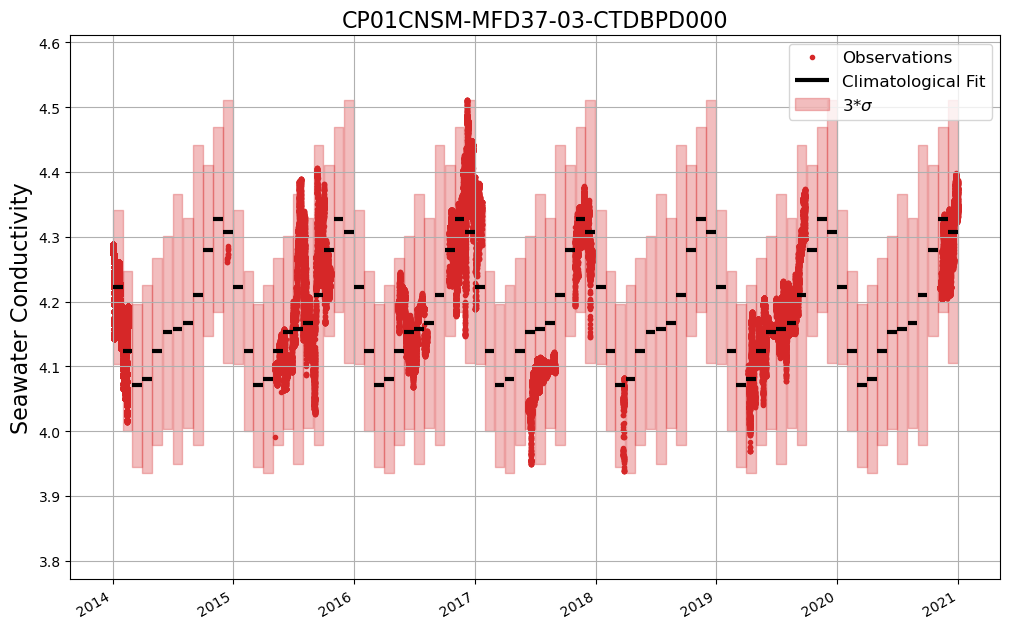

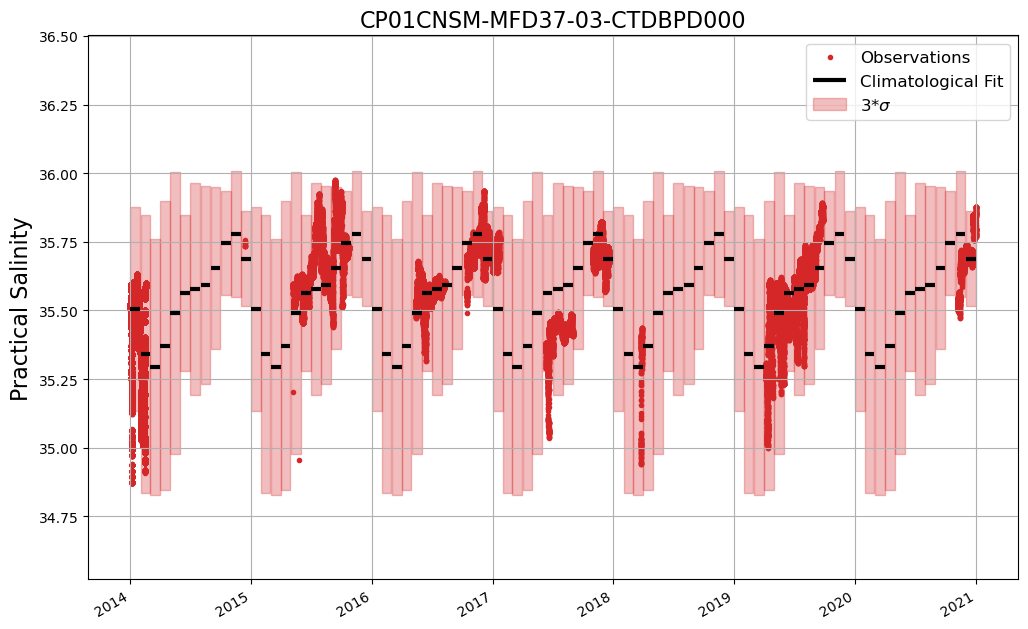

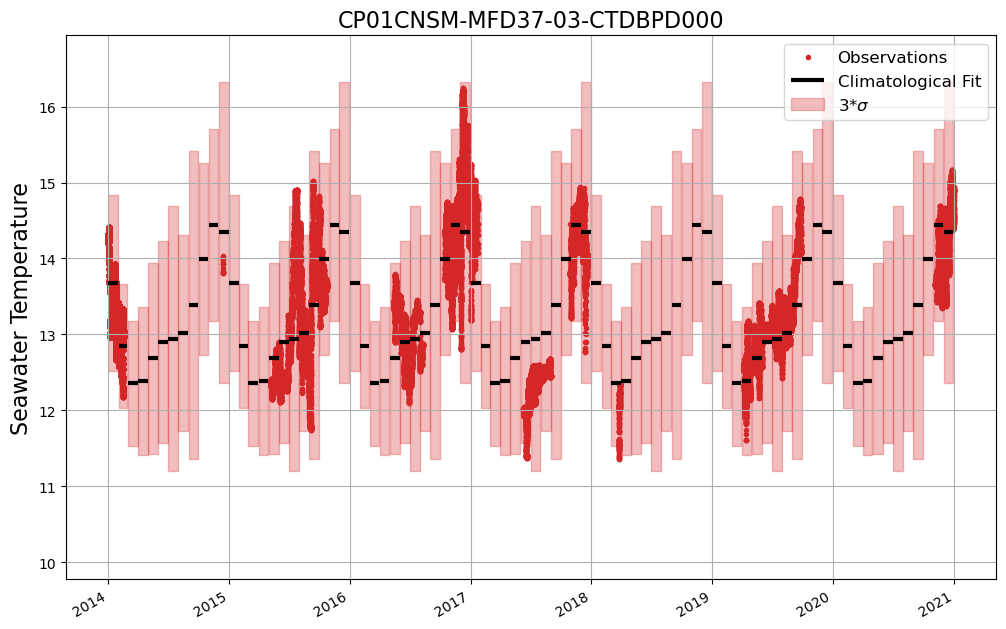

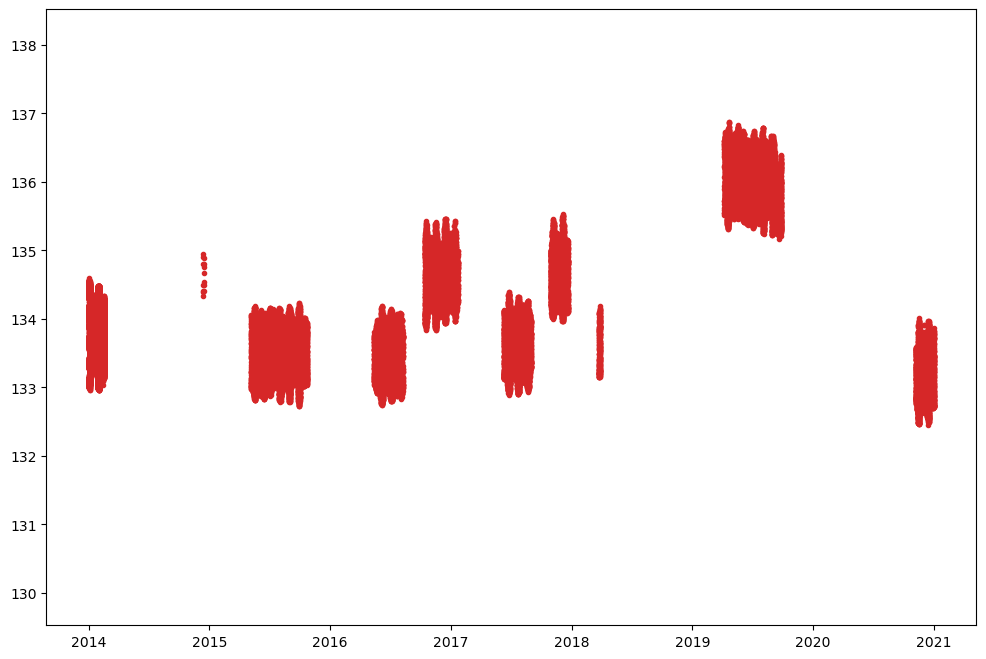

In [37]:
# Initialize the climatology lookup table
climatologyLookup = pd.DataFrame()

# Setup the Table Header
TBL_HEADER = ["[1,1]","[2,2]","[3,3]","[4,4]","[5,5]","[6,6]","[7,7]","[8,8]","[9,9]","[10,10]","[11,11]","[12,12]"]

# Set the subsite-node-sensor
subsite, node, sensor = refdes.split("-", 2)

# Iterate through the parameters
for param in test_parameters:
    if param in data.variables:
        # ----------------- Depth tables ---------------------
        # Get the sensor range of the parameter to test
        print(f"##### Calculating climatology for {param} #####")
        sensor_range = test_parameters.get(param).get("sensor_range")
        inp = test_parameters.get(param).get("inp")
        
        # Generate the climatology table with the depth bins
        climatologyTable, climatology = make_climatology_table(data, param, "time", "depth", sensor_range, depth_bins)
        
         # Get the variance and generate the source
        if "WFP" in refdes:
            source = "Climatology values are calculated from and applicable to standard depth bins."
        else:
            try:
                variance = float(np.round(climatology.regression['variance_explained']*100, 1))
            except:
                variance = 0.0
            source = f"The variance explained by the climatology mode is {variance}%"
        
        # Create the tableName
        tableName = f"{refdes}-{param}.csv"
        
        # Save the results
        climatologyTable.to_csv(f"../results/climatology/climatology_tables/{tableName}", header=TBL_HEADER)
        
        # ------------------ Lookup tables ------------------
        # Check which streams have the param in it
        for kinp in inp:               
            streams = metadata[metadata["particleKey"] == kinp]["stream"].unique()
            for stream in streams:
                qc_dict = {
                    "subsite": subsite,
                    "node": node,
                    "sensor": sensor,
                    "stream": stream,
                    "parameters": {
                        "inp": kinp,
                        "tinp": "time",
                        "zinp": "depth",
                    },
                    "climatologyTable": f"climatology_tables/{refdes}-{param}.csv",
                    "source": source,
                    "notes": "Climatology based on available data through 2021-01-01."
                }
                # Append to the lookup table
                climatologyLookup = climatologyLookup.append(qc_dict, ignore_index=True)
            
        # ------------------ Plot the climatology ------------------
        # --------------- Only plot if its NOT a WFP ---------------
        if data[param].time.size > 100000:
            try:
                subset = sorted(np.random.choice(data.time, 100000, replace=False))
                subset_data = data.sel(time=subset)
                plot_climatology(subset_data, param, climatology)
                del subset, subset_data
                gc.collect()
            except:
                pass
        else:
            try:
                plot_climatology(data, param, climatology)
            except:
                pass

**Check the last climatologyTable for reasonableness**

In [38]:
climatologyTable

,"[0, 1]","[1, 2]","[2, 3]","[3, 4]","[4, 5]","[5, 6]","[6, 7]","[7, 8]","[8, 9]","[9, 10]","[10, 11]","[11, 12]"
"[0, 0]","[132.60414, 134.8629]","[132.68864, 134.69859]","[132.66529, 134.52833]","[135.06328, 137.1211]","[130.47755, 138.63881]","[130.62765, 137.78766]","[130.75398, 137.53946]","[130.71902, 138.04562]","[131.12083, 138.25846]","[131.67704, 136.47748]","[131.94962, 136.41278]","[131.70084, 136.41043]"


**Check the climatologyLookup table that all the entries made it in**

In [39]:
climatologyLookup

,subsite,node,sensor,stream,parameters,climatologyTable,source,notes
0,CP01CNSM,MFD37,03-CTDBPD000,ctdbp_cdef_dcl_instrument,"{'inp': 'conductivity', 'tinp': 'time', 'zinp'...",climatology_tables/CP01CNSM-MFD37-03-CTDBPD000...,The variance explained by the climatology mode...,Climatology based on available data through 20...
1,CP01CNSM,MFD37,03-CTDBPD000,ctdbp_cdef_dcl_instrument_recovered,"{'inp': 'conductivity', 'tinp': 'time', 'zinp'...",climatology_tables/CP01CNSM-MFD37-03-CTDBPD000...,The variance explained by the climatology mode...,Climatology based on available data through 20...
2,CP01CNSM,MFD37,03-CTDBPD000,ctdbp_cdef_instrument_recovered,"{'inp': 'conductivity', 'tinp': 'time', 'zinp'...",climatology_tables/CP01CNSM-MFD37-03-CTDBPD000...,The variance explained by the climatology mode...,Climatology based on available data through 20...
3,CP01CNSM,MFD37,03-CTDBPD000,ctdbp_cdef_instrument_recovered,"{'inp': 'ctdbp_seawater_conductivity', 'tinp':...",climatology_tables/CP01CNSM-MFD37-03-CTDBPD000...,The variance explained by the climatology mode...,Climatology based on available data through 20...
4,CP01CNSM,MFD37,03-CTDBPD000,ctdbp_cdef_dcl_instrument,"{'inp': 'practical_salinity', 'tinp': 'time', ...",climatology_tables/CP01CNSM-MFD37-03-CTDBPD000...,The variance explained by the climatology mode...,Climatology based on available data through 20...
5,CP01CNSM,MFD37,03-CTDBPD000,ctdbp_cdef_dcl_instrument_recovered,"{'inp': 'practical_salinity', 'tinp': 'time', ...",climatology_tables/CP01CNSM-MFD37-03-CTDBPD000...,The variance explained by the climatology mode...,Climatology based on available data through 20...
6,CP01CNSM,MFD37,03-CTDBPD000,ctdbp_cdef_instrument_recovered,"{'inp': 'practical_salinity', 'tinp': 'time', ...",climatology_tables/CP01CNSM-MFD37-03-CTDBPD000...,The variance explained by the climatology mode...,Climatology based on available data through 20...
7,CP01CNSM,MFD37,03-CTDBPD000,ctdbp_cdef_dcl_instrument,"{'inp': 'temp', 'tinp': 'time', 'zinp': 'depth'}",climatology_tables/CP01CNSM-MFD37-03-CTDBPD000...,The variance explained by the climatology mode...,Climatology based on available data through 20...
8,CP01CNSM,MFD37,03-CTDBPD000,ctdbp_cdef_dcl_instrument_recovered,"{'inp': 'temp', 'tinp': 'time', 'zinp': 'depth'}",climatology_tables/CP01CNSM-MFD37-03-CTDBPD000...,The variance explained by the climatology mode...,Climatology based on available data through 20...
9,CP01CNSM,MFD37,03-CTDBPD000,ctdbp_cdef_instrument_recovered,"{'inp': 'ctdbp_seawater_temperature', 'tinp': ...",climatology_tables/CP01CNSM-MFD37-03-CTDBPD000...,The variance explained by the climatology mode...,Climatology based on available data through 20...


**Save the climatologyLookup table**

In [40]:
climatologyLookup.to_csv(f"../results/climatology/{refdes}.csv", index=False, columns=CLM_HEADER)